In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Run experiments

cd OPTWIN_PATH/Moa-Experiments/scripts/

./classification_experiments.sh

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
n_itt = 30

In [4]:
OPTWIN_PATH = "" #<-- DEFINE OPTWIN PATH
RESULT_FILE1 = OPTWIN_PATH+"/MOA-Experiments/results/nb_results/"
RESULT_FILE1 += "naive_bayes_RandomRBFGenerator_"
RESULT_FILE2 = ".csv"

In [5]:
save_plot = False
PLOT_SAVE_DIR="" #set path to save plot if save_plot=True

In [6]:
def plot_drifts(method, df, true_positives, false_positives, x_axis, y_axis, legend, separate_legend):
    drifts = [20000,40000,60000,80000]
    #df['classifications_correct_(percent)']
    plt.rcParams.update({'font.size': 20})
    plt.figure(figsize=(6,2.5))
    plt.title(method, fontsize = 20)
    if y_axis:
        plt.ylabel('Accuracy') 
    if x_axis:
        plt.xlabel('Stream datapoints') 
    
    for d in drifts:
        plt.vlines(d, 63, 65, colors = "black", linewidth=2)
        #plt.text(d+500, 80, "Drift", c = "black", fontsize = 10)
    
    for tp in true_positives:
        plt.vlines(tp, 63, 68, colors = "green", linewidth=1, linestyles = "dashed")
        #plt.text(d+500, 80, "Drift", c = "blue", fontsize = 10)
    
    
    for fp in false_positives:
        plt.vlines(fp, 69, 80, colors = "red", linewidth=1, linestyles = "dashed")
        #plt.text(d+500, 80, "Drift", c = "blue", fontsize = 10)
    
    if len(drifts) > 0 : plt.vlines(drifts[0], 63, 66, colors = "black", linewidth=2, label = "Drift")
    if len(true_positives) > 0 : plt.vlines(true_positives[0], 63, 69, colors = "green", linewidth=1, linestyles = "dashed", label = "TP")
    if len(false_positives) > 0 : plt.vlines(false_positives[0], 69, 80, colors = "red", linewidth=1, linestyles = "dashed", label = "FP")
    
    
    x1,x2,y1,y2 = plt.axis()
    plt.axis((1,99999,63,72))
    #plt.rcParams.update({'font.size': 30})
    
    df['classifications_correct_(percent)'].plot(label='')
    
    if legend:
        plt.legend(loc="lower right")
        if save_plot:
            plt.savefig(PLOT_SAVE_DIR+'agrawal_'+method.replace(' ', '')+'.svg', bbox_inches="tight") #save plot
        plt.show()
    elif separate_legend:
        plt.legend()
        ax = plt.gca()
        legend_handles, legend_labels = ax.get_legend_handles_labels() #get legends
        plt.gca().legend_ = None #remove legends
        if save_plot:
            plt.savefig(PLOT_SAVE_DIR+'agrawal_'+method.replace(' ', '')+'.svg', bbox_inches="tight") #save plot
        plt.show() #print plot without legends
        
        legend_figure = plt.figure() 
        plt.plot([], []) #create new empty plot
        plt.legend(legend_handles, legend_labels, loc='upper center', bbox_to_anchor=(0, 0), ncol=3) #add legends
        plt.axis('off') #remove axis
        plt.subplots_adjust(top=0.01, bottom=0, left=0.1, right=0.2)  # Reduce image size
        if save_plot:
            plt.savefig(PLOT_SAVE_DIR+'legend.svg', bbox_inches="tight") #save lagend

    else:
        if save_plot:
            plt.savefig(PLOT_SAVE_DIR+'randomRBF_'+method.replace(' ', '')+'.svg', bbox_inches="tight") #save plot
        plt.show()
    
    
    

    

In [7]:
def identify_metrics(method, n_itt, name, itt, x_axis, y_axis, legend, separate_legend):
    output = {}
    output['method'] = method
    #open n_itt results
    drift_detection = []
    for i in range(1,n_itt+1):
        RESULT_FILE = RESULT_FILE1+method+"_"+str(i)+"_"+str(drift_window)+RESULT_FILE2
        df = pd.read_csv(RESULT_FILE, low_memory=False)
        df.columns = [c.replace(' ', '_') for c in df.columns] #remove spaces from column names
        drift_detection.append(df)
        
    #get avg and std from n_itt runs
    drift_detection_concat =  pd.concat(drift_detection)
    drift_detection_concat = drift_detection_concat.drop('Kappa_Statistic_(percent)', axis=1) #remove unused statistic
    drift_detection_concat = drift_detection_concat.drop('Kappa_Temporal_Statistic_(percent)', axis=1) #remove unused statistic
    drift_detection_concat = drift_detection_concat.drop('Kappa_M_Statistic_(percent)', axis=1) #remove unused statistic
    drift_detection_avg = drift_detection_concat.groupby(drift_detection_concat.index).mean(numeric_only=True)
    drift_detection_sdv = drift_detection_concat.groupby(drift_detection_concat.index).std()

    output['avg_accuracy'] = drift_detection_avg['classifications_correct_(percent)'][len(drift_detection_avg.index)-1]
    output['std_accuracy'] = drift_detection_sdv['classifications_correct_(percent)'][len(drift_detection_sdv.index)-1]
    
    output['avg_cpu'] = drift_detection_avg['evaluation_time_(cpu_seconds)'][len(drift_detection_avg.index)-1]
    output['std_cpu'] = drift_detection_sdv['evaluation_time_(cpu_seconds)'][len(drift_detection_sdv.index)-1]
    
    output['avg_ram']  = drift_detection_avg['model_cost_(RAM-Hours)'][len(drift_detection_avg.index)-1]
    output['std_ram']  = drift_detection_sdv['model_cost_(RAM-Hours)'][len(drift_detection_sdv.index)-1]
    
    #get drift delays & true and false positives
    avg_delays = []
    false_positives = []
    true_positives = []
    list_true_positives = [] #index of true positives
    list_false_positives = [] #index of false_positives
    for i in range(len(drift_detection)):
        streams = []
        streams.append(drift_detection[i]['Change_detected'].iloc[:20000])
        streams.append(drift_detection[i]['Change_detected'].iloc[20000:40000])
        streams.append(drift_detection[i]['Change_detected'].iloc[40000:60000])
        streams.append(drift_detection[i]['Change_detected'].iloc[60000:80000])
        streams.append(drift_detection[i]['Change_detected'].iloc[80000:])
        
        

        delay = []
        fp = streams[0].sum()
        tp = 0
        l_true_positives = []
        l_false_positives = streams[0].eq(1).index[streams[0].eq(1)].tolist()
        for s in streams[1:]:
            if s.sum() >= 1: #drift identified in stream interval
                drifts_list = s.eq(1).index[s.eq(1)].tolist()
                tp += 1 #first drift is true
                l_true_positives.extend([drifts_list[0]])
                fp += s.sum() - 1 #other drifts are false positives
                l_false_positives.extend(drifts_list[1:])
                drift_init = s.index[0]
                drift_identified = s[s > 0].index[0]
                delay.append(drift_identified - drift_init)

        if len(delay) > 0:
            avg_delay = sum(delay) / len(delay)
            avg_delays.append(avg_delay)
        false_positives.append(fp)
        true_positives.append(tp)
        list_true_positives.append(l_true_positives)
        list_false_positives.append(l_false_positives)
    
    if len(avg_delays) > 0:
        output['avg_delay'] = sum(avg_delays) / len(avg_delays)
    else:
        output['avg_delay'] = 0
    output['std_delay'] = np.std(avg_delays)
    
    output['avg_fp'] = sum(false_positives) / len(false_positives)
    output['std_fp'] = np.std(false_positives)
    
    output['avg_tp'] = sum(true_positives) / len(true_positives)
    output['std_tp'] = np.std(true_positives)
    
    plot_drifts(name, drift_detection[itt], list_true_positives[itt], list_false_positives[itt], x_axis, y_axis, legend, separate_legend)
    
    return output

# ABRUPT DRIFT

In [8]:
drift_window = 1

### OPTWIN -r 0.1

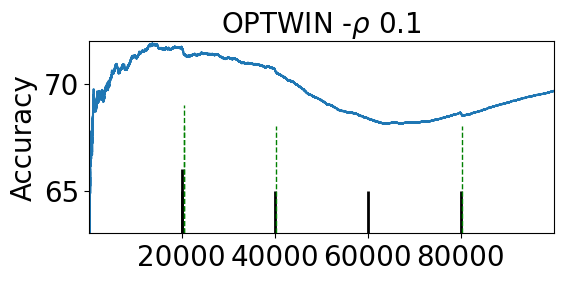

{'method': '(OPTWIN-r0.1)',
 'avg_accuracy': 69.651,
 'std_accuracy': 0.0,
 'avg_cpu': 44.232615233333334,
 'std_cpu': 1.9338973909575043,
 'avg_ram': 4.557644682770781e-08,
 'std_ram': 1.992368009281802e-09,
 'avg_delay': 315.0,
 'std_delay': 0.0,
 'avg_fp': 0.0,
 'std_fp': 0.0,
 'avg_tp': 3.0,
 'std_tp': 0.0}

In [9]:
method = "(OPTWIN-r0.1)"
itt = 0
name = r'OPTWIN -$\rho$ 0.1'
optwin01_output = identify_metrics(method, n_itt, name, itt, False, True, False, False)
optwin01_output

### OPTWIN -r 0.5

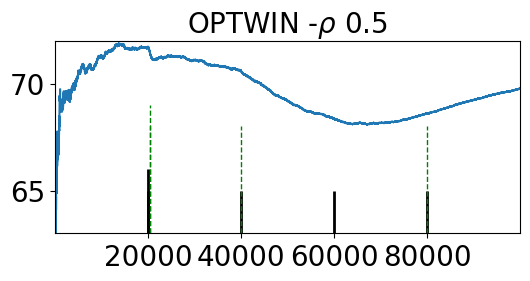

{'method': '(OPTWIN-r0.5)',
 'avg_accuracy': 69.76599999999999,
 'std_accuracy': 0.0,
 'avg_cpu': 44.84362416666667,
 'std_cpu': 0.9143920628340639,
 'avg_ram': 4.622417158702415e-08,
 'std_ram': 9.422646602990031e-10,
 'avg_delay': 187.0,
 'std_delay': 0.0,
 'avg_fp': 0.0,
 'std_fp': 0.0,
 'avg_tp': 3.0,
 'std_tp': 0.0}

In [10]:
method = "(OPTWIN-r0.5)"
itt = 0
name = r'OPTWIN -$\rho$ 0.5'
optwin05_output = identify_metrics(method, n_itt, name, itt, False, False, False, False)
optwin05_output

### OPTWIN -r 1.0

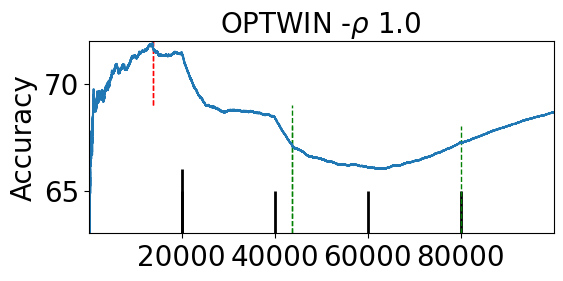

{'method': '(OPTWIN-r1.0)',
 'avg_accuracy': 68.66600000000001,
 'std_accuracy': 0.0,
 'avg_cpu': 45.102739033333336,
 'std_cpu': 0.69705029540869,
 'avg_ram': 4.654994413691263e-08,
 'std_ram': 7.193741416524277e-10,
 'avg_delay': 1931.5,
 'std_delay': 0.0,
 'avg_fp': 1.0,
 'std_fp': 0.0,
 'avg_tp': 2.0,
 'std_tp': 0.0}

In [11]:
method = "(OPTWIN-r1.0)"
itt = 0
name = r'OPTWIN -$\rho$ 1.0'
optwin10_output = identify_metrics(method, n_itt, name, itt, False, True, False, False)
optwin10_output

### ADWIN

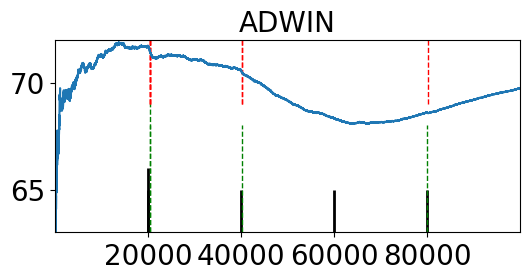

{'method': 'ADWINChangeDetector',
 'avg_accuracy': 69.736,
 'std_accuracy': 0.0,
 'avg_cpu': 26.404303433333332,
 'std_cpu': 1.1947713943832348,
 'avg_ram': 2.884134810452416e-08,
 'std_ram': 1.3059802111045533e-09,
 'avg_delay': 169.66666666666666,
 'std_delay': 5.684341886080802e-14,
 'avg_fp': 6.0,
 'std_fp': 0.0,
 'avg_tp': 3.0,
 'std_tp': 0.0}

In [12]:
method = "ADWINChangeDetector"
itt = 0
name = "ADWIN"
adwin_output = identify_metrics(method, n_itt, name, itt, False, False, False, False)
adwin_output

### DDM

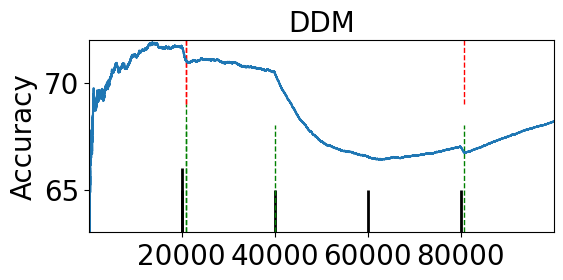

{'method': 'DDM',
 'avg_accuracy': 68.17699999999999,
 'std_accuracy': 0.0,
 'avg_cpu': 26.590238333333332,
 'std_cpu': 0.6037755184645439,
 'avg_ram': 1.8006532165876954e-08,
 'std_ram': 4.086070729852898e-10,
 'avg_delay': 536.3333333333336,
 'std_delay': 1.1368683772161603e-13,
 'avg_fp': 2.0,
 'std_fp': 0.0,
 'avg_tp': 3.0,
 'std_tp': 0.0}

In [13]:
method = "DDM"
itt = 0
name = method
ddm_output = identify_metrics(method, n_itt, name, itt, False, True, False, False)
ddm_output

### EDDM

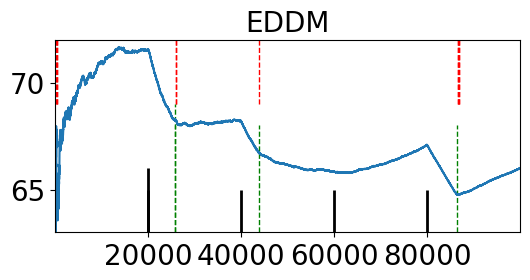

{'method': 'EDDM',
 'avg_accuracy': 65.994,
 'std_accuracy': 0.0,
 'avg_cpu': 23.9990171,
 'std_cpu': 0.26623037596067456,
 'avg_ram': 1.3259369863818382e-08,
 'std_ram': 1.470520460144287e-10,
 'avg_delay': 5354.666666666667,
 'std_delay': 1.8189894035458565e-12,
 'avg_fp': 11.0,
 'std_fp': 0.0,
 'avg_tp': 3.0,
 'std_tp': 0.0}

In [14]:
method = "EDDM"
itt = 0
name = method
eddm_output = identify_metrics(method, n_itt, name, itt, False, False, False, False)
eddm_output

### STEPD

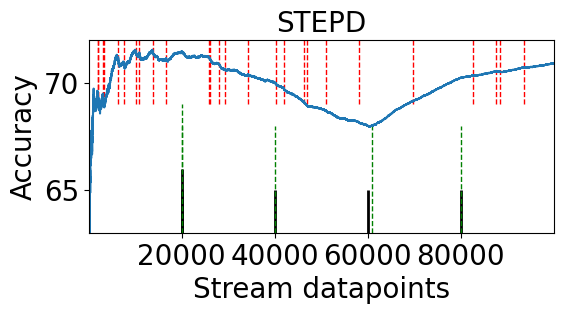

{'method': 'STEPD',
 'avg_accuracy': 70.922,
 'std_accuracy': 0.0,
 'avg_cpu': 26.6996675,
 'std_cpu': 1.6652961253473035,
 'avg_ram': 1.8933621420215025e-08,
 'std_ram': 1.1809414548578366e-09,
 'avg_delay': 281.25,
 'std_delay': 0.0,
 'avg_fp': 25.0,
 'std_fp': 0.0,
 'avg_tp': 4.0,
 'std_tp': 0.0}

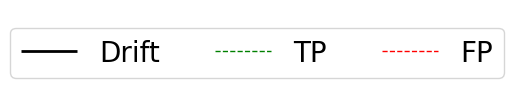

In [15]:
method = "STEPD"
itt = 0
name = method
stepd_output = identify_metrics(method, n_itt, name, itt, True, True, False, True)
stepd_output

### EWMAChartDM

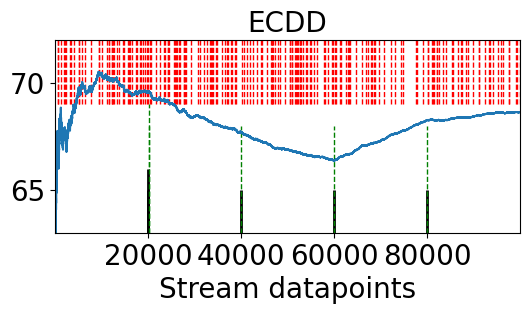

({'method': 'EWMAChartDM',
  'avg_accuracy': 68.636,
  'std_accuracy': 0.0,
  'avg_cpu': 25.907230566666666,
  'std_cpu': 0.6290755567743387,
  'avg_ram': 1.631924747579157e-08,
  'std_ram': 3.9625344698972816e-10,
  'avg_delay': 71.75,
  'std_delay': 0.0,
  'avg_fp': 174.0,
  'std_fp': 0.0,
  'avg_tp': 4.0,
  'std_tp': 0.0},)

In [16]:
method = "EWMAChartDM"
itt = 0
name = "ECDD"
EWMAChartDM_output = identify_metrics(method, n_itt, name, itt, True, False, False,False), 
EWMAChartDM_output

/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


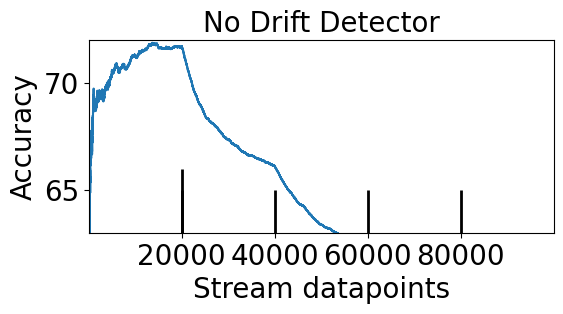

{'method': 'moa.classifiers.rules.core.changedetection.NoChangeDetection',
 'avg_accuracy': 58.692,
 'std_accuracy': 0.0,
 'avg_cpu': 24.156252733333336,
 'std_cpu': 0.4273069220666387,
 'avg_ram': 1.2648461472517247e-08,
 'std_ram': 2.237422832243888e-10,
 'avg_delay': 0,
 'std_delay': nan,
 'avg_fp': 0.0,
 'std_fp': 0.0,
 'avg_tp': 0.0,
 'std_tp': 0.0}

In [17]:
method = "moa.classifiers.rules.core.changedetection.NoChangeDetection"
itt = 0
name = "No Drift Detector"
no_output = identify_metrics(method, n_itt, name, itt, True, True, False, False)
no_output

# GRADUAL DRIFT

In [18]:
drift_window = 1000

### OPTWIN -r 0.1

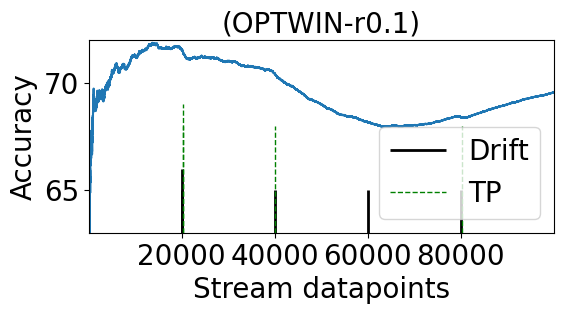

{'method': '(OPTWIN-r0.1)',
 'avg_accuracy': 69.56400000000001,
 'std_accuracy': 0.0,
 'avg_cpu': 45.37566866666667,
 'std_cpu': 1.0767314655603222,
 'avg_ram': 4.668369080547054e-08,
 'std_ram': 1.1075915368269506e-09,
 'avg_delay': 226.66666666666677,
 'std_delay': 5.684341886080802e-14,
 'avg_fp': 0.0,
 'std_fp': 0.0,
 'avg_tp': 3.0,
 'std_tp': 0.0}

In [19]:
method = "(OPTWIN-r0.1)"
itt = 0
name = method
optwin01_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
optwin01_gradual_output

### OPTWIN -r 0.5

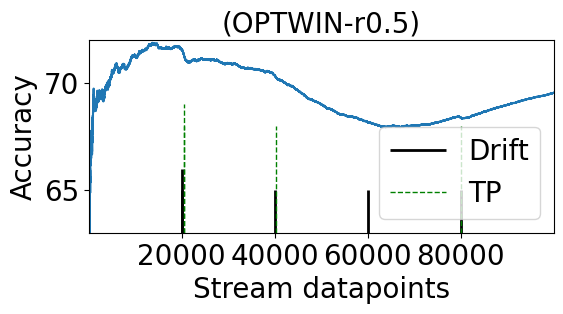

{'method': '(OPTWIN-r0.5)',
 'avg_accuracy': 69.544,
 'std_accuracy': 0.0,
 'avg_cpu': 45.43400843333333,
 'std_cpu': 0.5296026903814011,
 'avg_ram': 4.681297827215371e-08,
 'std_ram': 5.456581086618294e-10,
 'avg_delay': 336.0,
 'std_delay': 0.0,
 'avg_fp': 0.0,
 'std_fp': 0.0,
 'avg_tp': 3.0,
 'std_tp': 0.0}

In [20]:
method = "(OPTWIN-r0.5)"
itt = 0
name = method
optwin05_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
optwin05_gradual_output

### OPTWIN -r 1.0

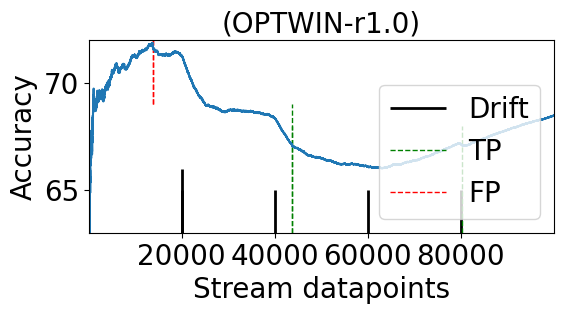

{'method': '(OPTWIN-r1.0)',
 'avg_accuracy': 68.477,
 'std_accuracy': 0.0,
 'avg_cpu': 45.35113,
 'std_cpu': 1.15555572080202,
 'avg_ram': 4.6798882557699955e-08,
 'std_ram': 1.1923061124179836e-09,
 'avg_delay': 2040.0,
 'std_delay': 0.0,
 'avg_fp': 1.0,
 'std_fp': 0.0,
 'avg_tp': 2.0,
 'std_tp': 0.0}

In [21]:
method = "(OPTWIN-r1.0)"
itt = 0
name = method
optwin10_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
optwin10_gradual_output

### ADWIN

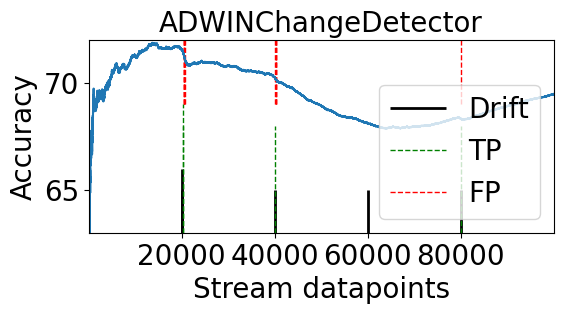

{'method': 'ADWINChangeDetector',
 'avg_accuracy': 69.48299999999999,
 'std_accuracy': 0.0,
 'avg_cpu': 26.760269433333335,
 'std_cpu': 1.980684595700021,
 'avg_ram': 2.9286940094910254e-08,
 'std_ram': 2.1680373498633873e-09,
 'avg_delay': 191.0,
 'std_delay': 0.0,
 'avg_fp': 9.0,
 'std_fp': 0.0,
 'avg_tp': 3.0,
 'std_tp': 0.0}

In [22]:
method = "ADWINChangeDetector"
itt = 0
name = method
adwin_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
adwin_gradual_output

### DDM

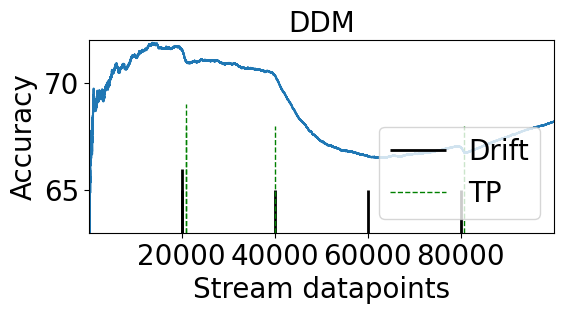

{'method': 'DDM',
 'avg_accuracy': 68.192,
 'std_accuracy': 0.0,
 'avg_cpu': 25.306441,
 'std_cpu': 0.43684246808771443,
 'avg_ram': 1.7189289216228287e-08,
 'std_ram': 2.9689593417755046e-10,
 'avg_delay': 575.0,
 'std_delay': 0.0,
 'avg_fp': 0.0,
 'std_fp': 0.0,
 'avg_tp': 3.0,
 'std_tp': 0.0}

In [23]:
method = "DDM"
itt = 0
name = method
ddm_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
ddm_gradual_output

### EDDM

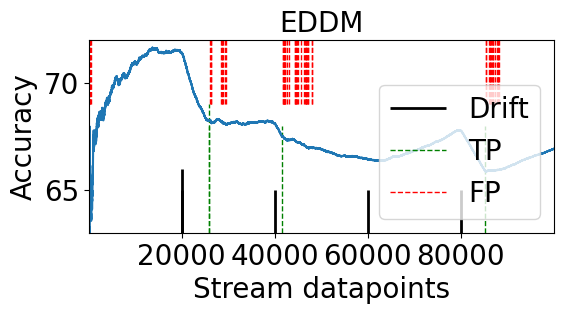

{'method': 'EDDM',
 'avg_accuracy': 66.923,
 'std_accuracy': 0.0,
 'avg_cpu': 23.966136666666667,
 'std_cpu': 0.7757967704028359,
 'avg_ram': 1.3236532463106105e-08,
 'std_ram': 4.2856290174993384e-10,
 'avg_delay': 4258.666666666669,
 'std_delay': 9.094947017729282e-13,
 'avg_fp': 53.0,
 'std_fp': 0.0,
 'avg_tp': 3.0,
 'std_tp': 0.0}

In [24]:
method = "EDDM"
itt = 0
name = method
eddm_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
eddm_gradual_output

### STEPD

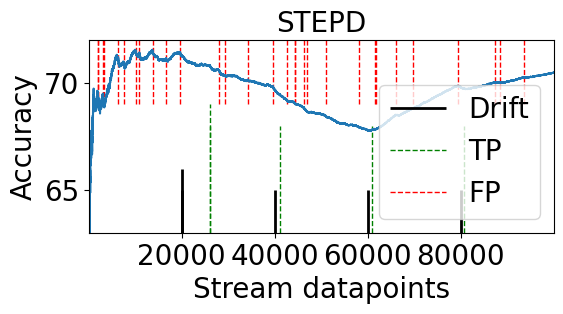

{'method': 'STEPD',
 'avg_accuracy': 70.486,
 'std_accuracy': 0.0,
 'avg_cpu': 26.672315,
 'std_cpu': 1.3387985924416175,
 'avg_ram': 1.8913930103738223e-08,
 'std_ram': 9.494076394222373e-10,
 'avg_delay': 2219.5,
 'std_delay': 0.0,
 'avg_fp': 29.0,
 'std_fp': 0.0,
 'avg_tp': 4.0,
 'std_tp': 0.0}

In [25]:
method = "STEPD"
itt = 0
name = method
stepd_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
stepd_gradual_output

### EWMAChartDM

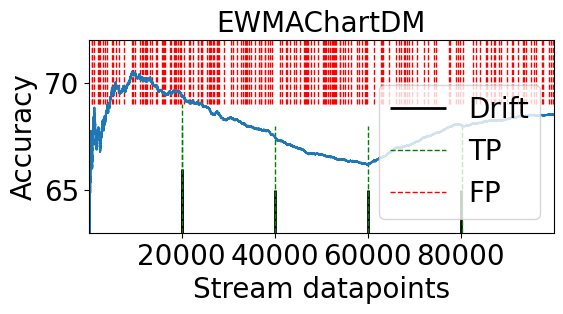

{'method': 'EWMAChartDM',
 'avg_accuracy': 68.52000000000001,
 'std_accuracy': 0.0,
 'avg_cpu': 24.93896853333333,
 'std_cpu': 0.4836191465800444,
 'avg_ram': 1.5709474422383217e-08,
 'std_ram': 3.046825961001747e-10,
 'avg_delay': 153.0,
 'std_delay': 0.0,
 'avg_fp': 167.0,
 'std_fp': 0.0,
 'avg_tp': 4.0,
 'std_tp': 0.0}

In [26]:
method = "EWMAChartDM"
itt = 0
name = method
EWMAChartDM_gradual_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
EWMAChartDM_gradual_output

/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


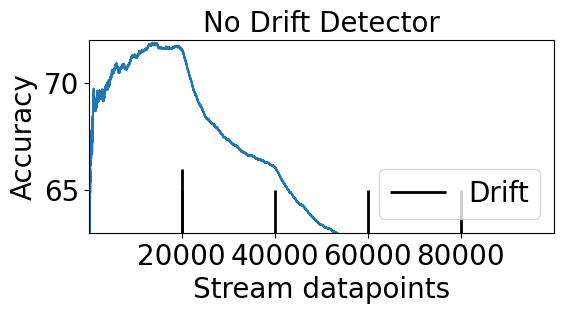

{'method': 'moa.classifiers.rules.core.changedetection.NoChangeDetection',
 'avg_accuracy': 58.68,
 'std_accuracy': 0.0,
 'avg_cpu': 23.854408866666667,
 'std_cpu': 0.6155175361279441,
 'avg_ram': 1.2490412930783691e-08,
 'std_ram': 3.222912894363343e-10,
 'avg_delay': 0,
 'std_delay': nan,
 'avg_fp': 0.0,
 'std_fp': 0.0,
 'avg_tp': 0.0,
 'std_tp': 0.0}

In [27]:
method = "moa.classifiers.rules.core.changedetection.NoChangeDetection"
itt = 0
name = "No Drift Detector"
no_output = identify_metrics(method, n_itt, name, itt, True, True, True, True)
no_output